In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [4]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [5]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [6]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

print(bitcoin_df)
print(nasdaq_df)
print(usd_df)

           Date    Price       Open       High        Low    Vol. Change %
4110 2013-03-01     34.5       33.4       34.9       32.9  39.79K    3.36%
4109 2013-03-02     34.3       34.5       34.8       33.2  36.66K   -0.72%
4108 2013-03-03     34.5       34.3       34.5       33.8  12.53K    0.73%
4107 2013-03-04     36.2       34.5       36.7       34.2  46.77K    4.78%
4106 2013-03-05     40.3       36.2       40.7       36.2  85.43K   11.56%
...         ...      ...        ...        ...        ...     ...      ...
4    2024-05-28  68366.0  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
3    2024-05-29  67635.8  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
2    2024-05-30  68354.7  67,631.30  69,504.70  67,138.40  66.84K    1.06%
1    2024-05-31  67530.1  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
0    2024-06-01  67760.8  67,533.90  67,861.00  67,449.60  19.01K    0.34%

[4111 rows x 7 columns]
           Date     Price       Open       High        Low     Vol. Change 

# DATASET BITCOIN

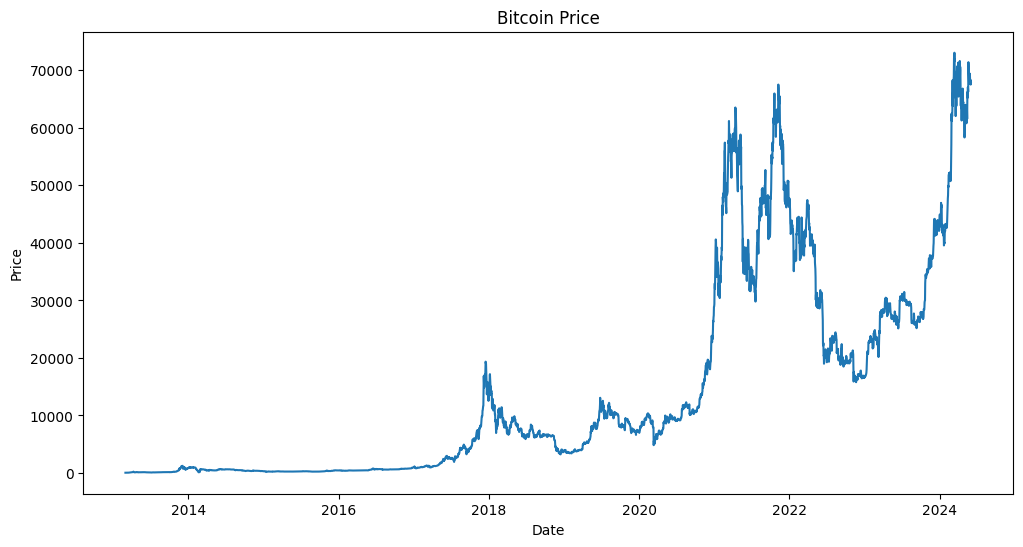

In [7]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


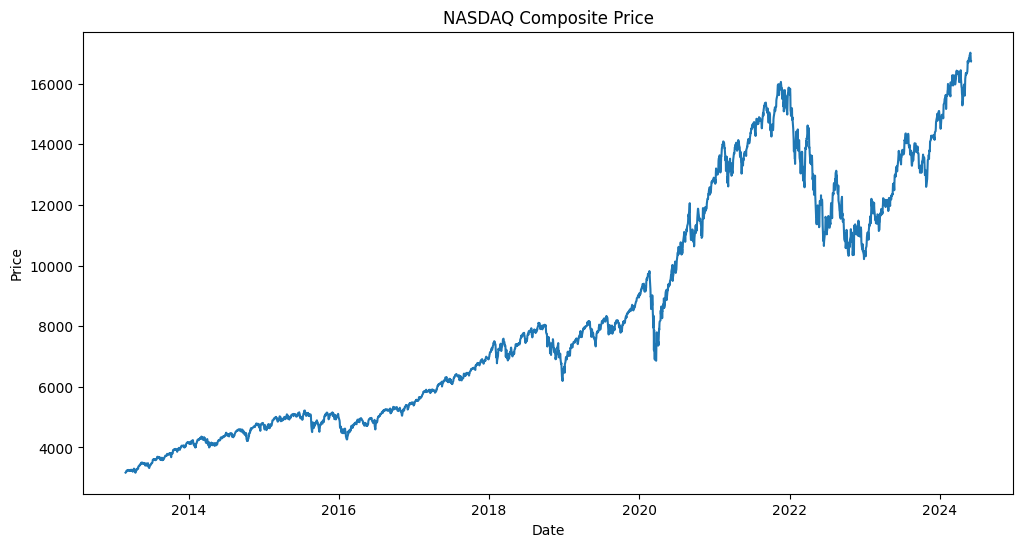

In [8]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

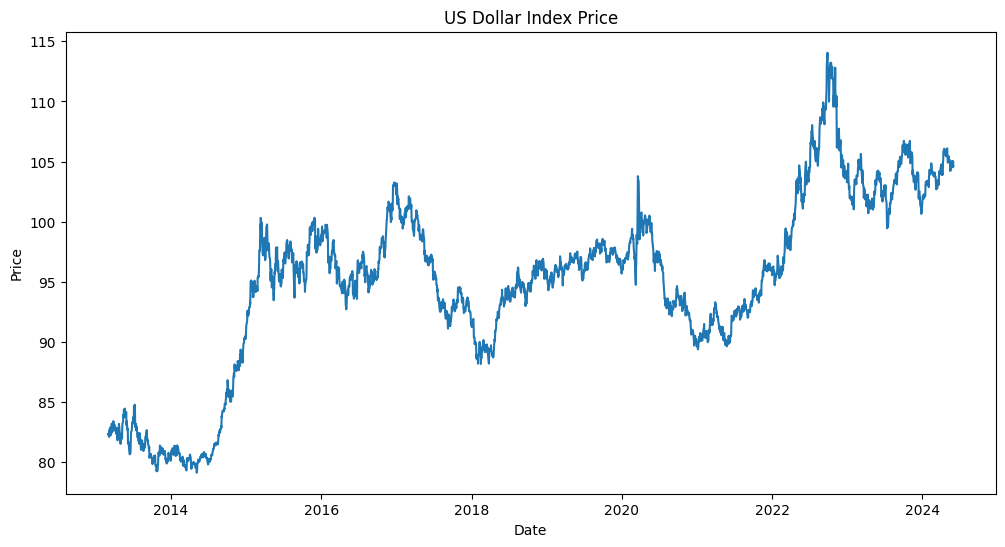

In [9]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []

    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
# Function to forecast future prices
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)
    print(forecast_prices)
    return forecast_prices.flatten()

In [12]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [13]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [14]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

In [15]:
# Function to process the dataset and plot the results
def process_dataset(df, dataset_name, sequence_length=30, split_ratio=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']].values)
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

    # Predictions
    predicted_prices = model.predict(X_test)

    # Inverse transform to get actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted_prices_actual = scaler.inverse_transform(predicted_prices).flatten()

    # Evaluation
    mae, mape, rmse = evaluate_model(actual_prices, predicted_prices_actual)

    # Forecast future prices
    future_steps = 30
    future_forecast_1 = forecast_future(model, scaled_data, future_steps, scaler)
    future_forecast_2 = forecast_future(model, scaler.transform(future_forecast_1.reshape(-1, 1)), future_steps, scaler)
    future_forecast_3 = forecast_future(model, scaler.transform(future_forecast_2.reshape(-1, 1)), future_steps, scaler)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    future_dates_1 = pd.date_range(df['Date'].iloc[-1], periods=future_steps + 1)[1:]
    future_dates_2 = pd.date_range(future_dates_1[-1], periods=future_steps + 1)[1:]
    future_dates_3 = pd.date_range(future_dates_2[-1], periods=future_steps + 1)[1:]

    plt.plot(future_dates_1, future_forecast_1, color='red', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(future_dates_2, future_forecast_2, color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(future_dates_3, future_forecast_3, color='brown', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'LSTM {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4

Epoch 1/100
35/35 [==============================] - 13s 165ms/step - loss: 3.7778e-04 - val_loss: 2.4913e-04
Epoch 2/100
35/35 [==============================] - 2s 63ms/step - loss: 1.0500e-04 - val_loss: 1.9798e-04
Epoch 3/100
35/35 [==============================] - 2s 63ms/step - loss: 8.0603e-05 - val_loss: 1.9810e-04
Epoch 4/100
35/35 [==============================] - 2s 62ms/step - loss: 7.8516e-05 - val_loss: 1.5128e-04
Epoch 5/100
35/35 [==============================] - 2s 56ms/step - loss: 7.7087e-05 - val_loss: 1.3363e-04
Epoch 6/100
35/35 [==============================] - 2s 49ms/step - loss: 6.7844e-05 - val_loss: 1.2159e-04
Epoch 7/100
35/35 [==============================] - 3s 77ms/step - loss: 5.7039e-05 - val_loss: 1.2605e-04
Epoch 8/100
35/35 [==============================] - 2s 69ms/step - loss: 5.1892e-05 - val_loss: 1.1376e-04
Epoch 9/100
35/35 [==============================] - 2s 47ms/step - loss: 5.9885e-05 - val_loss: 1.0102e-04
Epoch 10/100
35/35 [======

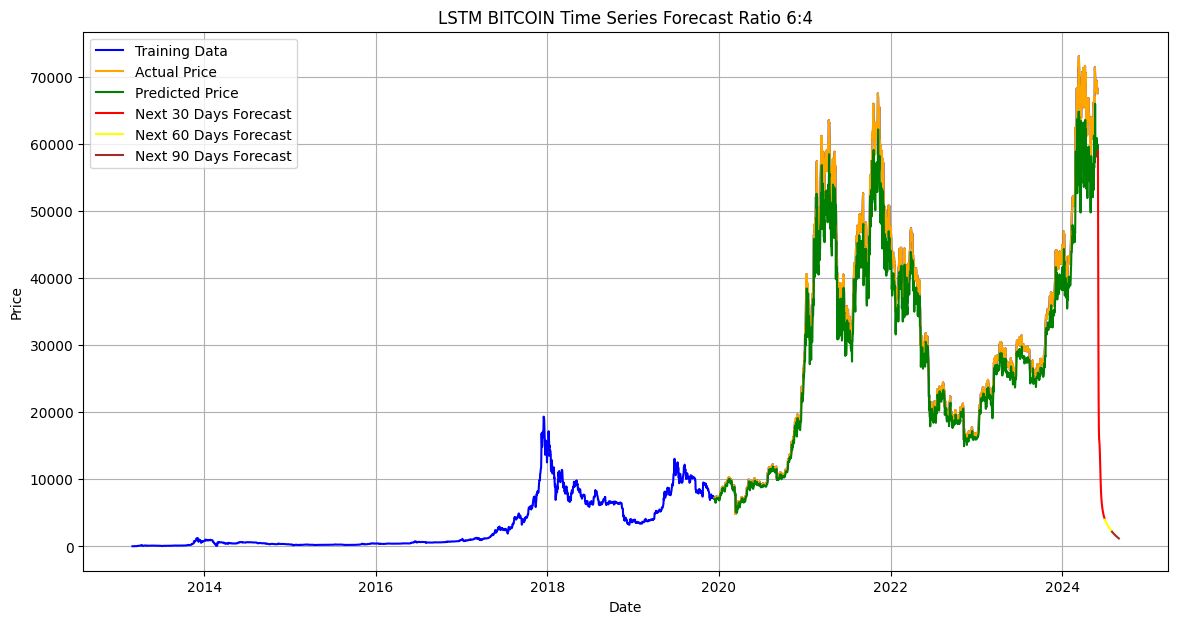

Testing MAE: 2564.9801
Testing RMSE: 3705.7604
Testing MAPE: 6.63%


In [16]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
41/41 [==============================] - 8s 77ms/step - loss: 5.4526e-04 - val_loss: 0.0017
Epoch 2/100
41/41 [==============================] - 3s 66ms/step - loss: 1.1313e-04 - val_loss: 0.0012
Epoch 3/100
41/41 [==============================] - 3s 77ms/step - loss: 1.1033e-04 - val_loss: 0.0012
Epoch 4/100
41/41 [==============================] - 2s 46ms/step - loss: 8.6376e-05 - val_loss: 9.8779e-04
Epoch 5/100
41/41 [==============================] - 2s 46ms/step - loss: 7.4928e-05 - val_loss: 9.6014e-04
Epoch 6/100
41/41 [==============================] - 2s 46ms/step - loss: 7.7449e-05 - val_loss: 6.5559e-04
Epoch 7/100
41/41 [==============================] - 2s 46ms/step - loss: 6.8520e-05 - val_loss: 5.9158e-04
Epoch 8/100
41/41 [==============================] - 2s 45ms/step - loss: 6.9222e-05 - val_loss: 9.9211e-04
Epoch 9/100
41/41 [==============================] - 3s 67ms/step - loss: 6.3505e-05 - val_loss: 9.9612e-04
Epoch 10/100
41/41 [====================

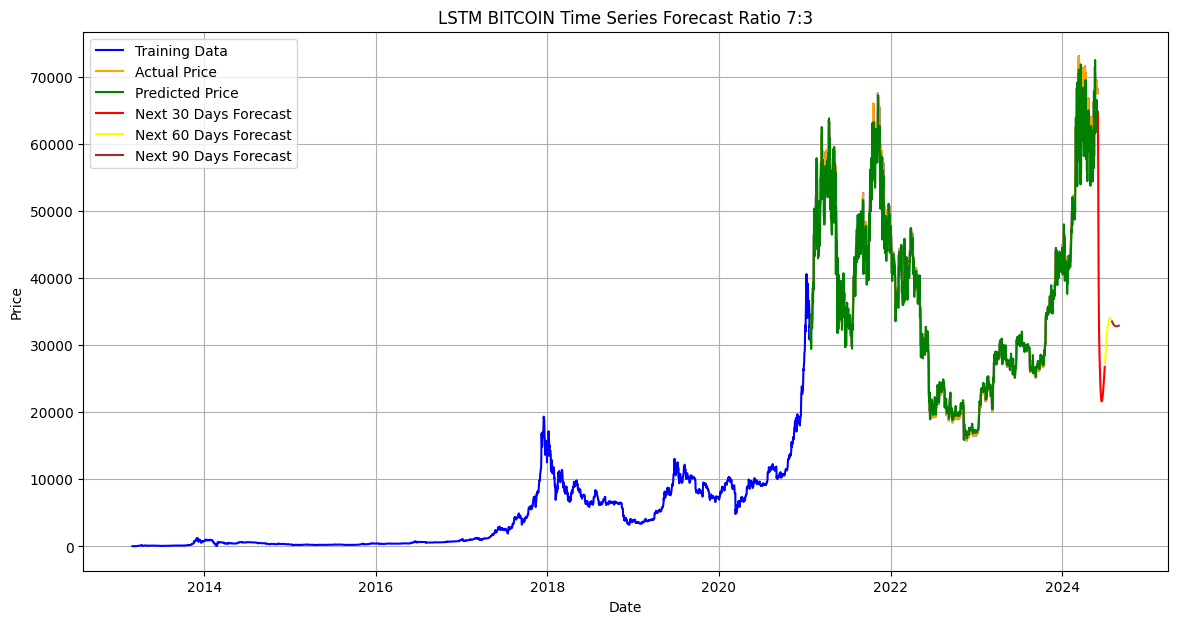

Testing MAE: 1528.3065
Testing RMSE: 2380.9367
Testing MAPE: 3.59%


In [17]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
46/46 [==============================] - 10s 73ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 2/100
46/46 [==============================] - 2s 47ms/step - loss: 3.9221e-04 - val_loss: 0.0092
Epoch 3/100
46/46 [==============================] - 2s 47ms/step - loss: 3.0746e-04 - val_loss: 0.0045
Epoch 4/100
46/46 [==============================] - 3s 75ms/step - loss: 3.3423e-04 - val_loss: 0.0064
Epoch 5/100
46/46 [==============================] - 3s 66ms/step - loss: 3.2870e-04 - val_loss: 0.0100
Epoch 6/100
46/46 [==============================] - 2s 47ms/step - loss: 3.1841e-04 - val_loss: 0.0047
Epoch 7/100
46/46 [==============================] - 2s 48ms/step - loss: 2.7678e-04 - val_loss: 0.0035
Epoch 8/100
46/46 [==============================] - 2s 47ms/step - loss: 2.4939e-04 - val_loss: 0.0172
Epoch 9/100
46/46 [==============================] - 2s 47ms/step - loss: 2.6937e-04 - val_loss: 0.0073
Epoch 10/100
46/46 [==============================] - 3s 76ms/step 

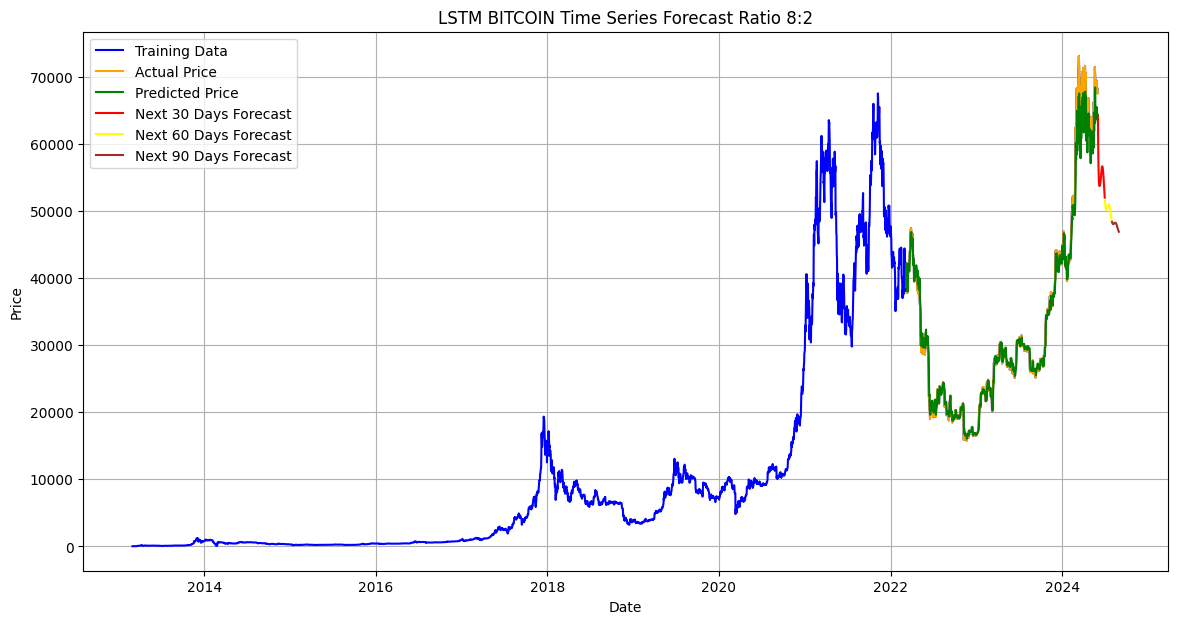

Testing MAE: 938.2181
Testing RMSE: 1635.7487
Testing MAPE: 2.45%


In [18]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Epoch 1/100
24/24 [==============================] - 8s 97ms/step - loss: 0.0046 - val_loss: 2.6689e-04
Epoch 2/100
24/24 [==============================] - 1s 47ms/step - loss: 3.1384e-04 - val_loss: 4.2834e-04
Epoch 3/100
24/24 [==============================] - 1s 47ms/step - loss: 1.4441e-04 - val_loss: 2.5712e-04
Epoch 4/100
24/24 [==============================] - 1s 46ms/step - loss: 1.2598e-04 - val_loss: 2.3895e-04
Epoch 5/100
24/24 [==============================] - 1s 46ms/step - loss: 1.2491e-04 - val_loss: 2.4945e-04
Epoch 6/100
24/24 [==============================] - 1s 46ms/step - loss: 1.2572e-04 - val_loss: 2.4720e-04
Epoch 7/100
24/24 [==============================] - 1s 63ms/step - loss: 1.3513e-04 - val_loss: 2.3731e-04
Epoch 8/100
24/24 [==============================] - 2s 78ms/step - loss: 1.2029e-04 - val_loss: 2.2891e-04
Epoch 9/100
24/24 [==============================] - 2s 81ms/step - loss: 1.1881e-04 - val_loss: 2.5758e-04
Epoch 10/100
24/24 [============

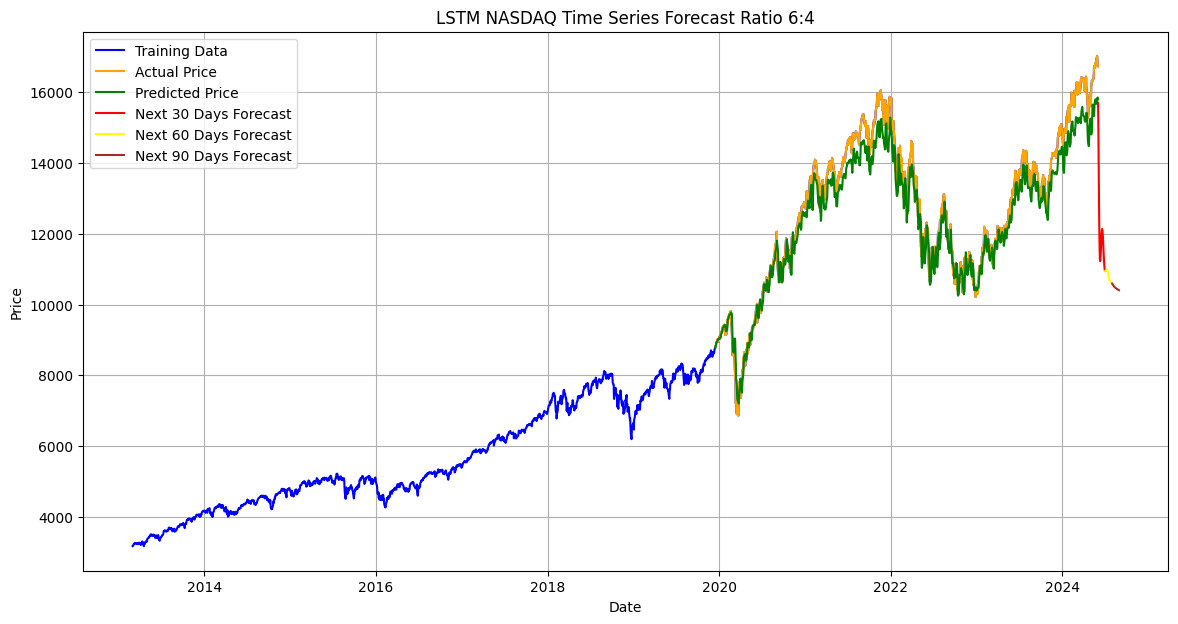

Testing MAE: 405.3989
Testing RMSE: 501.5597
Testing MAPE: 3.02%


In [19]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
28/28 [==============================] - 9s 124ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 2/100
28/28 [==============================] - 1s 46ms/step - loss: 4.3608e-04 - val_loss: 0.0023
Epoch 3/100
28/28 [==============================] - 1s 47ms/step - loss: 2.5828e-04 - val_loss: 6.9629e-04
Epoch 4/100
28/28 [==============================] - 1s 47ms/step - loss: 2.3223e-04 - val_loss: 0.0012
Epoch 5/100
28/28 [==============================] - 1s 46ms/step - loss: 2.2933e-04 - val_loss: 0.0017
Epoch 6/100
28/28 [==============================] - 1s 46ms/step - loss: 2.2221e-04 - val_loss: 0.0021
Epoch 7/100
28/28 [==============================] - 1s 46ms/step - loss: 2.4899e-04 - val_loss: 0.0015
Epoch 8/100
28/28 [==============================] - 1s 49ms/step - loss: 2.1726e-04 - val_loss: 0.0013
Epoch 9/100
28/28 [==============================] - 2s 75ms/step - loss: 1.9815e-04 - val_loss: 0.0015
Epoch 10/100
28/28 [==============================] - 2s 81ms/s

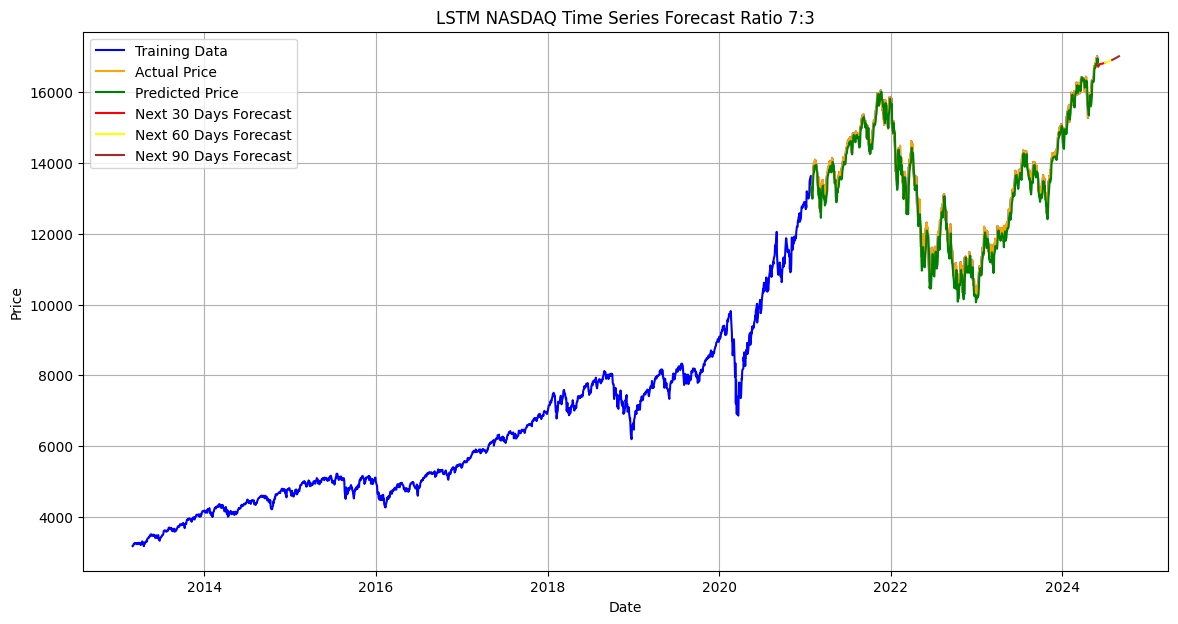

Testing MAE: 204.7814
Testing RMSE: 258.3704
Testing MAPE: 1.57%


In [20]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
32/32 [==============================] - 9s 87ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 2/100
32/32 [==============================] - 2s 49ms/step - loss: 6.0773e-04 - val_loss: 0.0013
Epoch 3/100
32/32 [==============================] - 2s 61ms/step - loss: 3.5246e-04 - val_loss: 0.0012
Epoch 4/100
32/32 [==============================] - 3s 82ms/step - loss: 3.5445e-04 - val_loss: 0.0013
Epoch 5/100
32/32 [==============================] - 2s 69ms/step - loss: 3.3329e-04 - val_loss: 0.0012
Epoch 6/100
32/32 [==============================] - 2s 49ms/step - loss: 3.4048e-04 - val_loss: 0.0012
Epoch 7/100
32/32 [==============================] - 2s 48ms/step - loss: 3.3394e-04 - val_loss: 0.0012
Epoch 8/100
32/32 [==============================] - 2s 50ms/step - loss: 3.2786e-04 - val_loss: 0.0011
Epoch 9/100
32/32 [==============================] - 2s 49ms/step - loss: 3.1033e-04 - val_loss: 0.0011
Epoch 10/100
32/32 [==============================] - 2s 49ms/step -

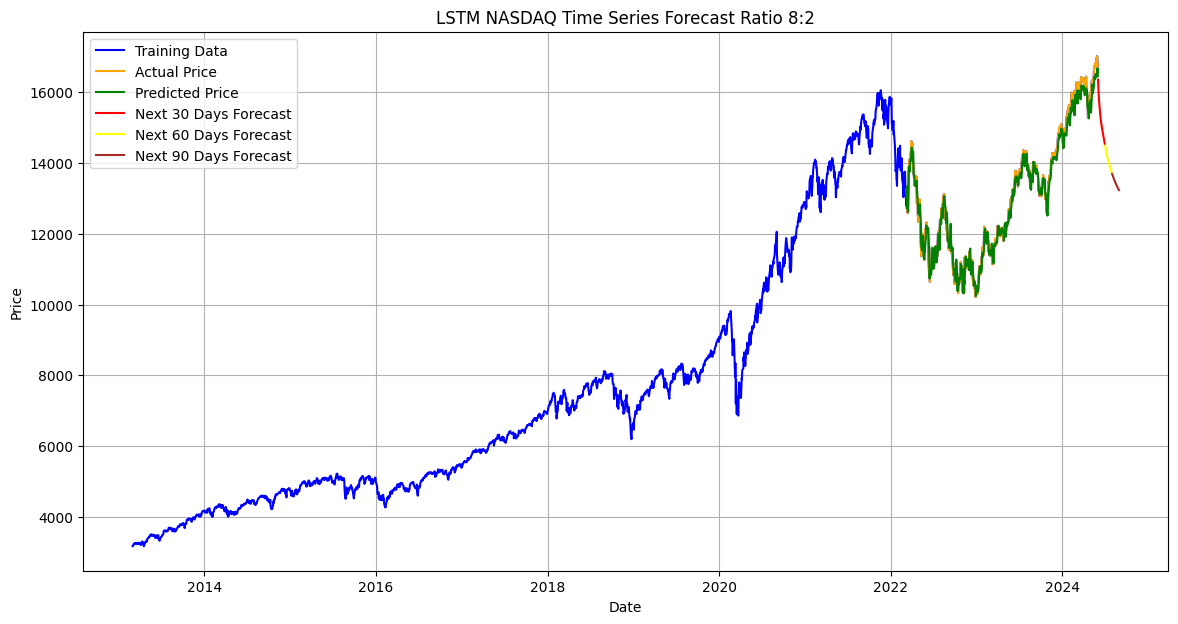

Testing MAE: 190.2522
Testing RMSE: 236.3619
Testing MAPE: 1.46%


In [21]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Epoch 1/100
25/25 [==============================] - 8s 93ms/step - loss: 0.0246 - val_loss: 0.0025
Epoch 2/100
25/25 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 6.5336e-04
Epoch 3/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0011 - val_loss: 3.4816e-04
Epoch 4/100
25/25 [==============================] - 1s 46ms/step - loss: 0.0010 - val_loss: 3.0148e-04
Epoch 5/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0010 - val_loss: 3.0106e-04
Epoch 6/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0010 - val_loss: 3.0767e-04
Epoch 7/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0010 - val_loss: 4.7209e-04
Epoch 8/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0010 - val_loss: 5.1211e-04
Epoch 9/100
25/25 [==============================] - 1s 46ms/step - loss: 9.9522e-04 - val_loss: 3.1047e-04
Epoch 10/100
25/25 [==============================] - 1s 46ms/st

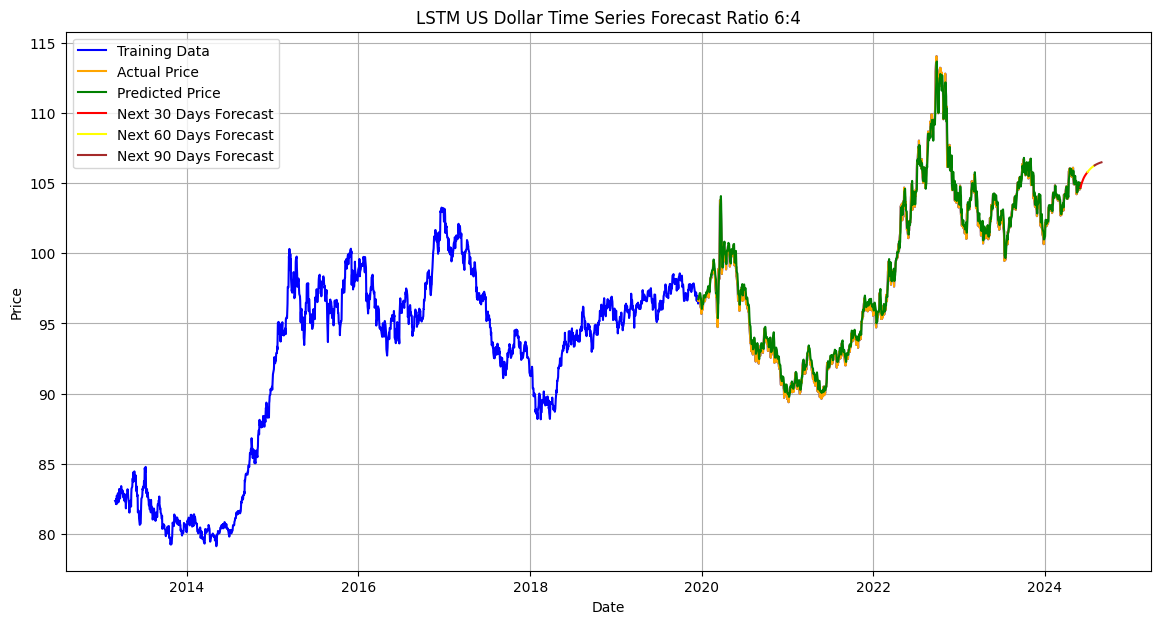

Testing MAE: 0.3993
Testing RMSE: 0.5311
Testing MAPE: 0.40%


In [22]:
results = process_dataset(usd_df, "US Dollar", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
29/29 [==============================] - 8s 90ms/step - loss: 0.0245 - val_loss: 0.0021
Epoch 2/100
29/29 [==============================] - 2s 68ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
29/29 [==============================] - 2s 81ms/step - loss: 9.9785e-04 - val_loss: 8.1985e-04
Epoch 4/100
29/29 [==============================] - 2s 61ms/step - loss: 9.8952e-04 - val_loss: 9.8487e-04
Epoch 5/100
29/29 [==============================] - 1s 49ms/step - loss: 9.5736e-04 - val_loss: 0.0016
Epoch 6/100
29/29 [==============================] - 1s 50ms/step - loss: 9.8857e-04 - val_loss: 8.6833e-04
Epoch 7/100
29/29 [==============================] - 1s 49ms/step - loss: 9.4693e-04 - val_loss: 6.6965e-04
Epoch 8/100
29/29 [==============================] - 1s 49ms/step - loss: 9.2740e-04 - val_loss: 0.0011
Epoch 9/100
29/29 [==============================] - 1s 48ms/step - loss: 8.9805e-04 - val_loss: 6.6762e-04
Epoch 10/100
29/29 [==============================] 

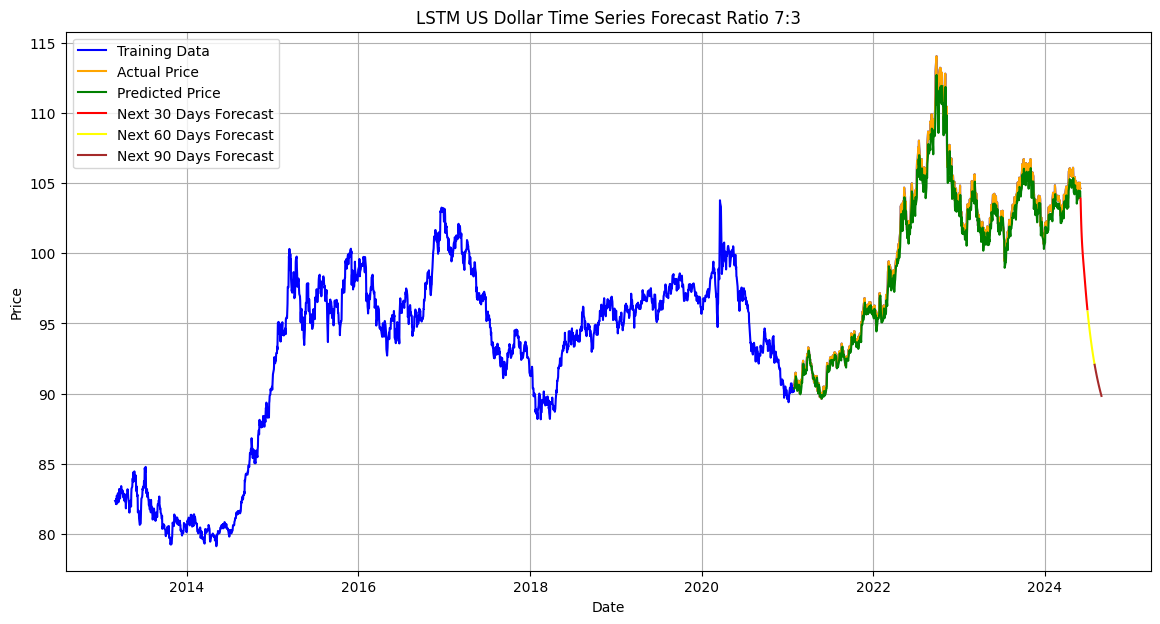

Testing MAE: 0.5764
Testing RMSE: 0.7315
Testing MAPE: 0.56%


In [23]:
results = process_dataset(usd_df, "US Dollar", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
33/33 [==============================] - 9s 124ms/step - loss: 0.0226 - val_loss: 0.0019
Epoch 2/100
33/33 [==============================] - 1s 45ms/step - loss: 0.0017 - val_loss: 7.5193e-04
Epoch 3/100
33/33 [==============================] - 2s 46ms/step - loss: 9.7155e-04 - val_loss: 6.8198e-04
Epoch 4/100
33/33 [==============================] - 1s 45ms/step - loss: 9.4464e-04 - val_loss: 5.8363e-04
Epoch 5/100
33/33 [==============================] - 1s 45ms/step - loss: 9.1833e-04 - val_loss: 5.3948e-04
Epoch 6/100
33/33 [==============================] - 1s 45ms/step - loss: 9.1986e-04 - val_loss: 6.0953e-04
Epoch 7/100
33/33 [==============================] - 2s 46ms/step - loss: 9.1323e-04 - val_loss: 5.5142e-04
Epoch 8/100
33/33 [==============================] - 2s 65ms/step - loss: 9.0557e-04 - val_loss: 5.1042e-04
Epoch 9/100
33/33 [==============================] - 3s 77ms/step - loss: 8.6552e-04 - val_loss: 5.0958e-04
Epoch 10/100
33/33 [===================

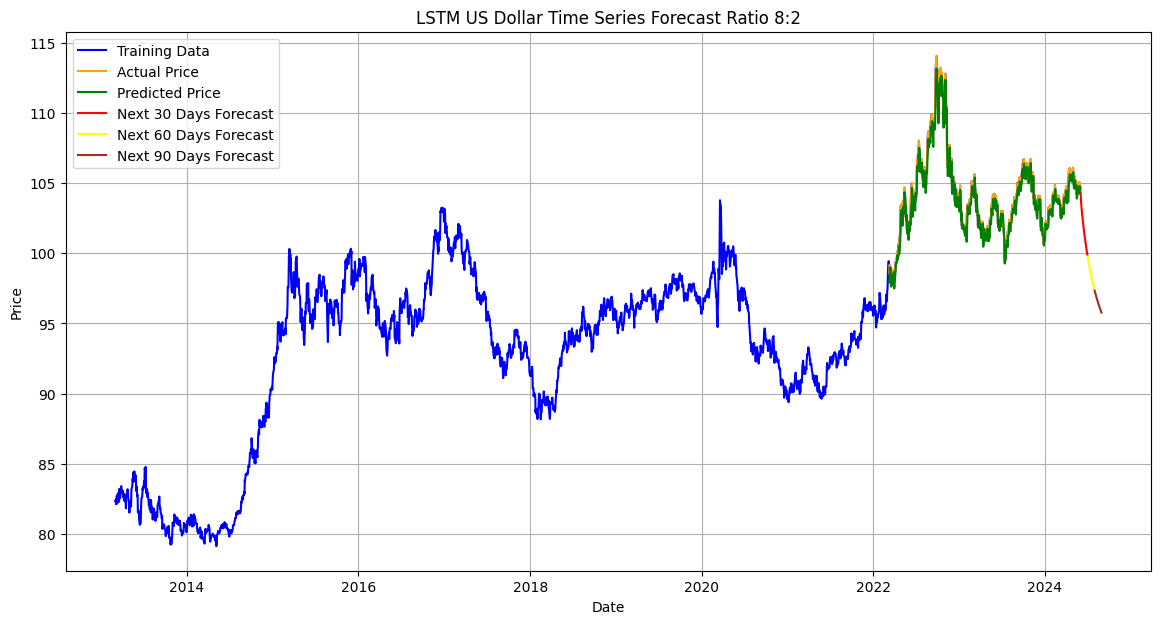

Testing MAE: 0.4726
Testing RMSE: 0.6096
Testing MAPE: 0.45%


In [24]:
results = process_dataset(usd_df, "US Dollar", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')